In [61]:
#Import models

from keras.models import load_model
import keras.utils as image
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K
from keras import models
import tensorflow as tf
import cv2
tf.compat.v1.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [2]:
model = load_model('./../convnet_dog_cat/cats_and_dogs_small_2.h5')
model.summary()

2023-11-26 10:08:56.477644: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/lib/x86_64-linux-gnu/:/usr/local/cuda-11/targets/x86_64-linux/lib/:/opt/oracle:/opt/oracle/lib/:
2023-11-26 10:08:56.478264: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-26 10:08:56.478316: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (killuamam-KLVL-WXX9): /proc/driver/nvidia/version does not exist
2023-11-26 10:08:56.479562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable th

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [3]:
img_path = './../convnet_dog_cat/dogs-vs-cats-data-small/test/cats/cat.1700.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)

img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)



(1, 150, 150, 3)


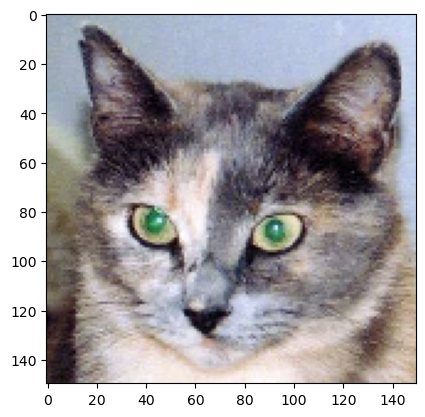

In [4]:
# display image
plt.imshow(img_tensor[0])
plt.show()

In [5]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)


## 1. Visualizing intermediate activations

In [6]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 266ms/step


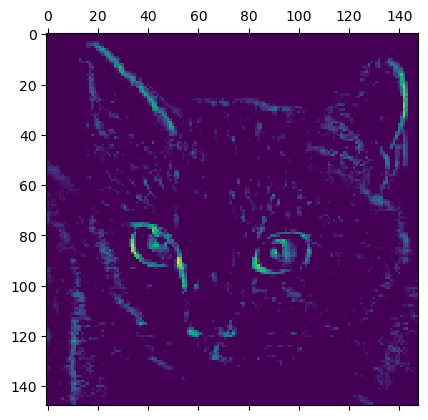

In [7]:
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

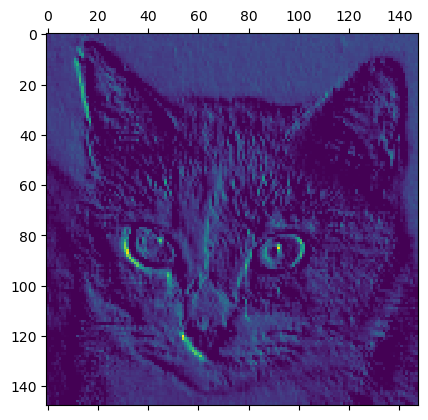

In [8]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

/tmp/ipykernel_7971/1562549692.py:32: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


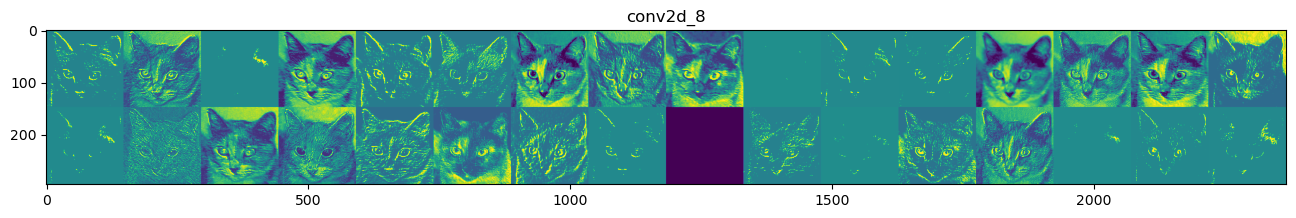

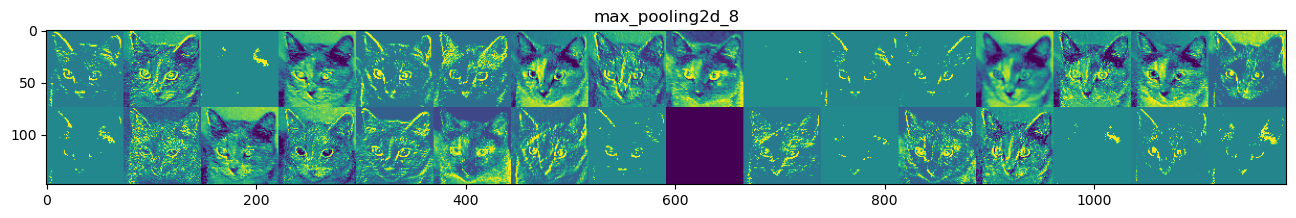

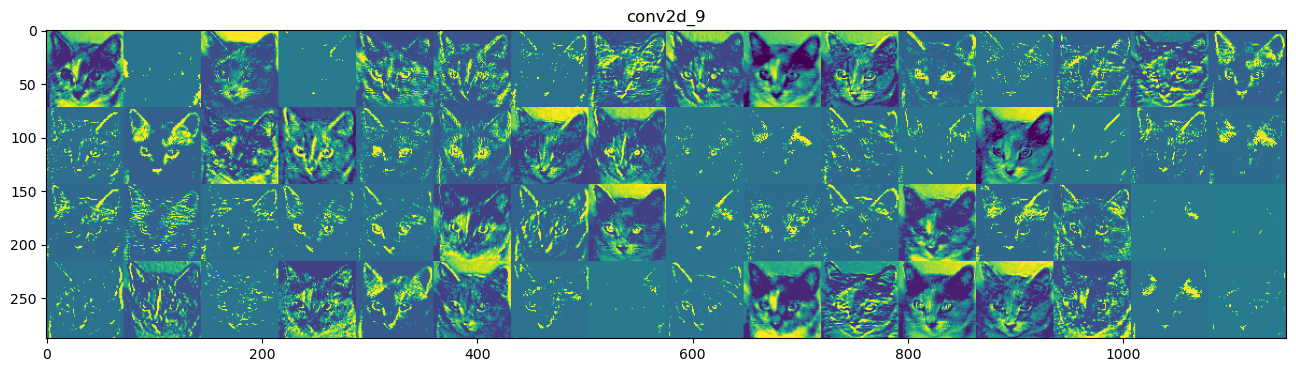

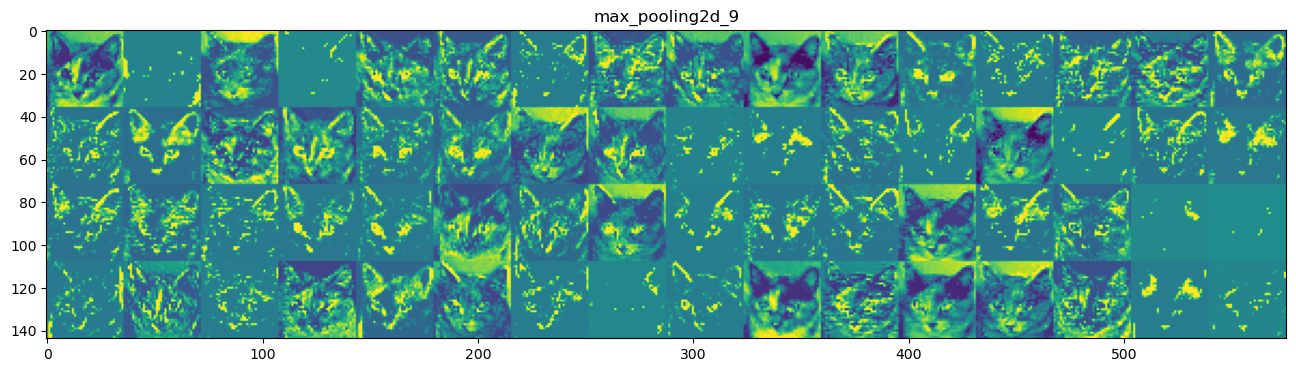

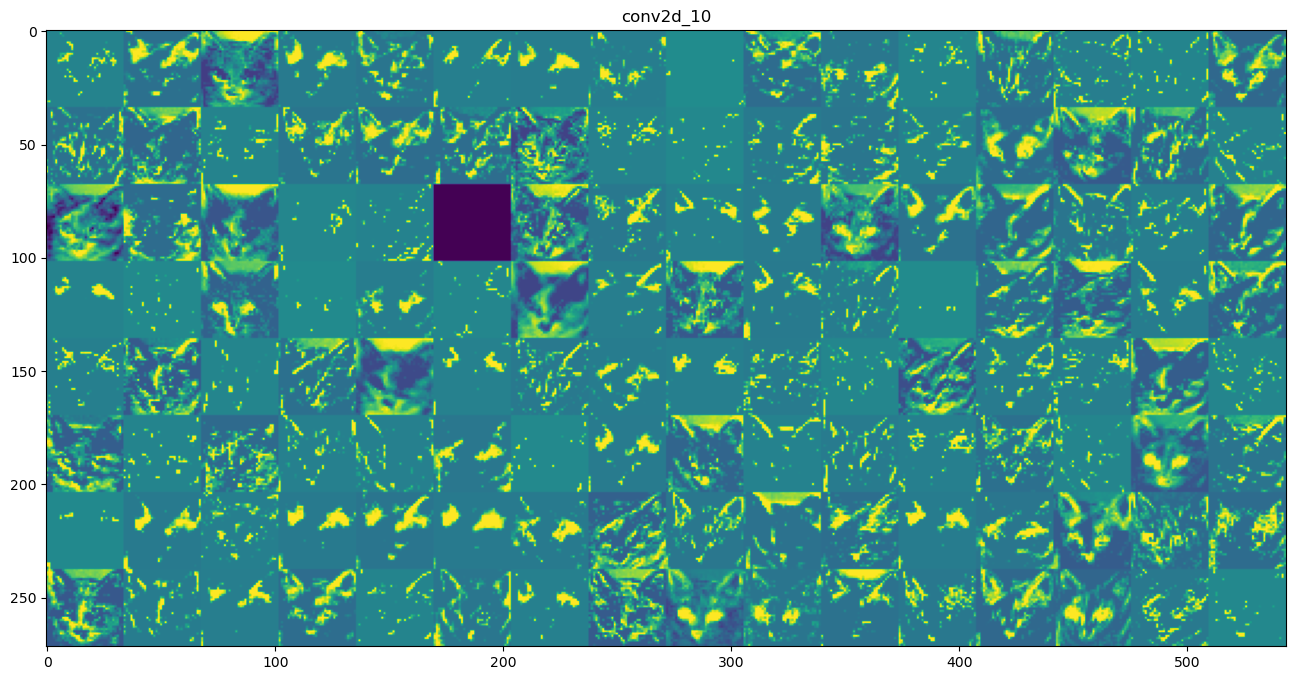

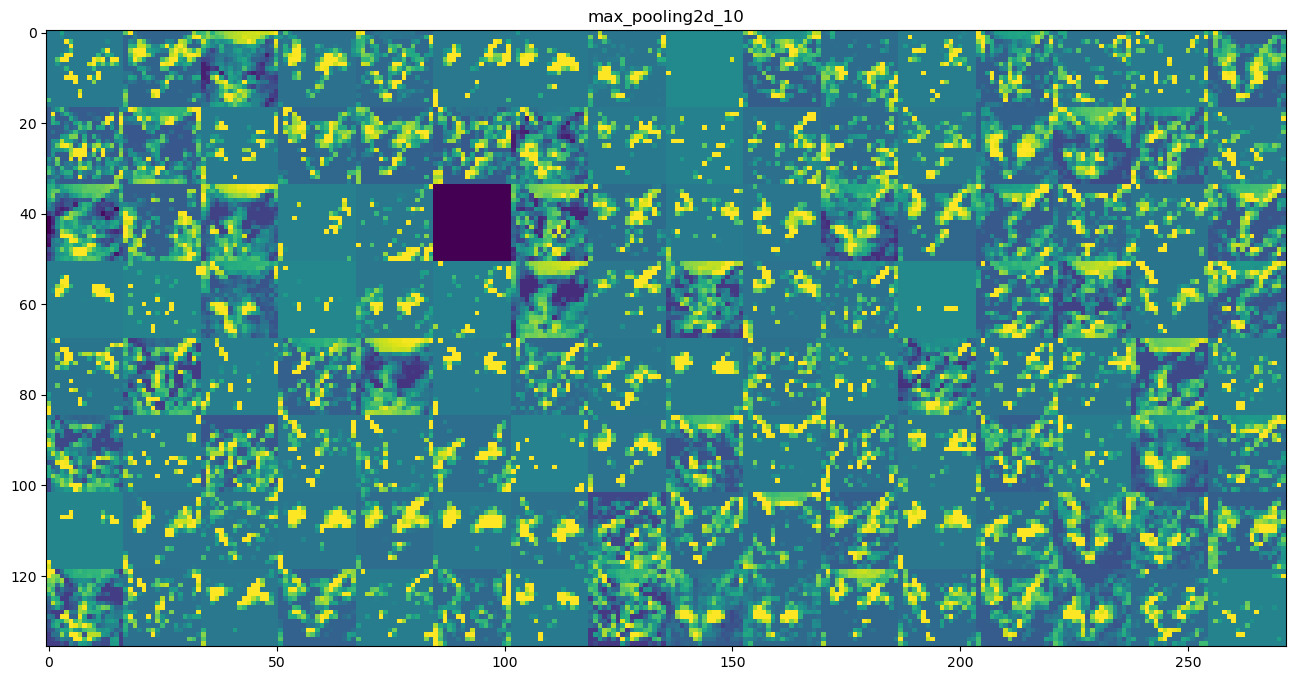

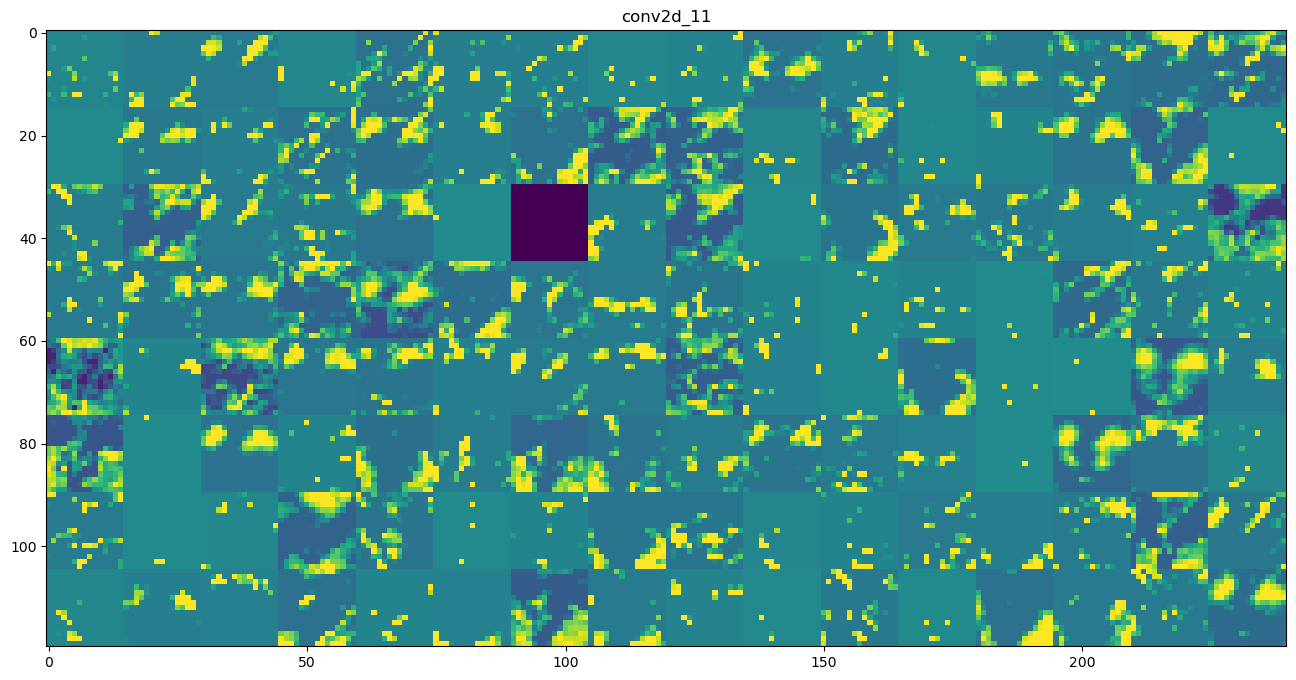

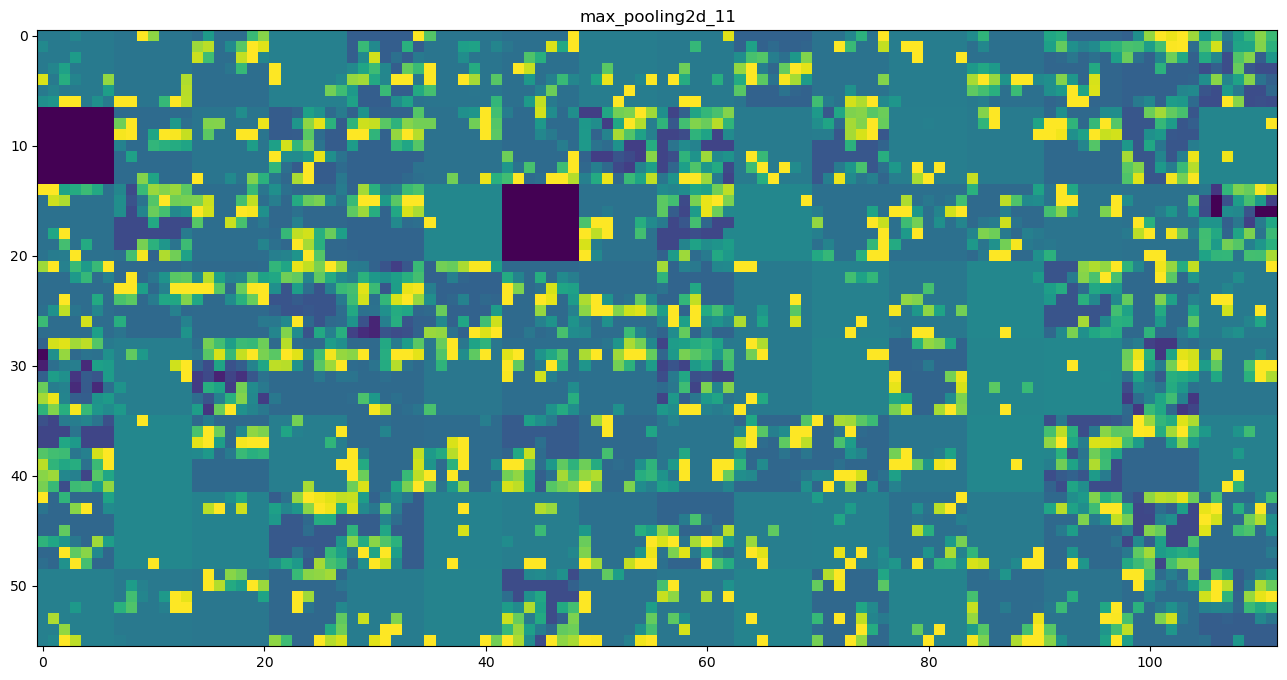

In [9]:
# show what each channel detects

layer_names = []
for layer in model.layers[:8]:

    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):

    n_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row

    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):

        for row in range(images_per_row):

            channel_image = layer_activation[0,

                                             :, :,

                                             col * images_per_row + row]

            channel_image -= channel_image.mean()

            channel_image /= channel_image.std()

            channel_image *= 64

            channel_image += 128

            channel_image = np.clip(channel_image, 0, 255).astype('uint8')

            display_grid[col * size : (col + 1) * size,

                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size

    plt.figure(figsize=(scale * display_grid.shape[1],

                        scale * display_grid.shape[0]))

    plt.title(layer_name)

    plt.grid(False)

    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## 2. Visualizing convnet filters

In [17]:
model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

grads = K.gradients(loss, model.input)[0]


2023-11-26 10:28:28.638358: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [21]:

grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss, grads])

loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [22]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.

for i in range(40):
    
        loss_value, grads_value = iterate([input_img_data])
    
        input_img_data += grads_value * step

In [23]:
def deprocess_image(x):
    
        x -= x.mean()
    
        x /= (x.std() + 1e-5)
    
        x *= 0.1
    
        x += 0.5
    
        x = np.clip(x, 0, 1)
    
        x *= 255
    
        x = np.clip(x, 0, 255).astype('uint8')
    
        return x

In [26]:
def generate_pattern(layer_name, filter_index, size=150):
    
        layer_output = model.get_layer(layer_name).output
    
        loss = K.mean(layer_output[:, :, :, filter_index])
    
        grads = K.gradients(loss, model.input)[0]
    
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
        iterate = K.function([model.input], [loss, grads])
    
        input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
        step = 1.
    
        for i in range(40):
    
            loss_value, grads_value = iterate([input_img_data])
    
            input_img_data += grads_value * step
    
        img = input_img_data[0]
    
        return deprocess_image(img)

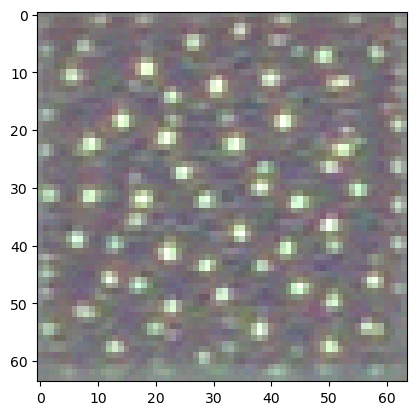

In [34]:
plt.imshow(generate_pattern('block3_conv1', 0, size=64))

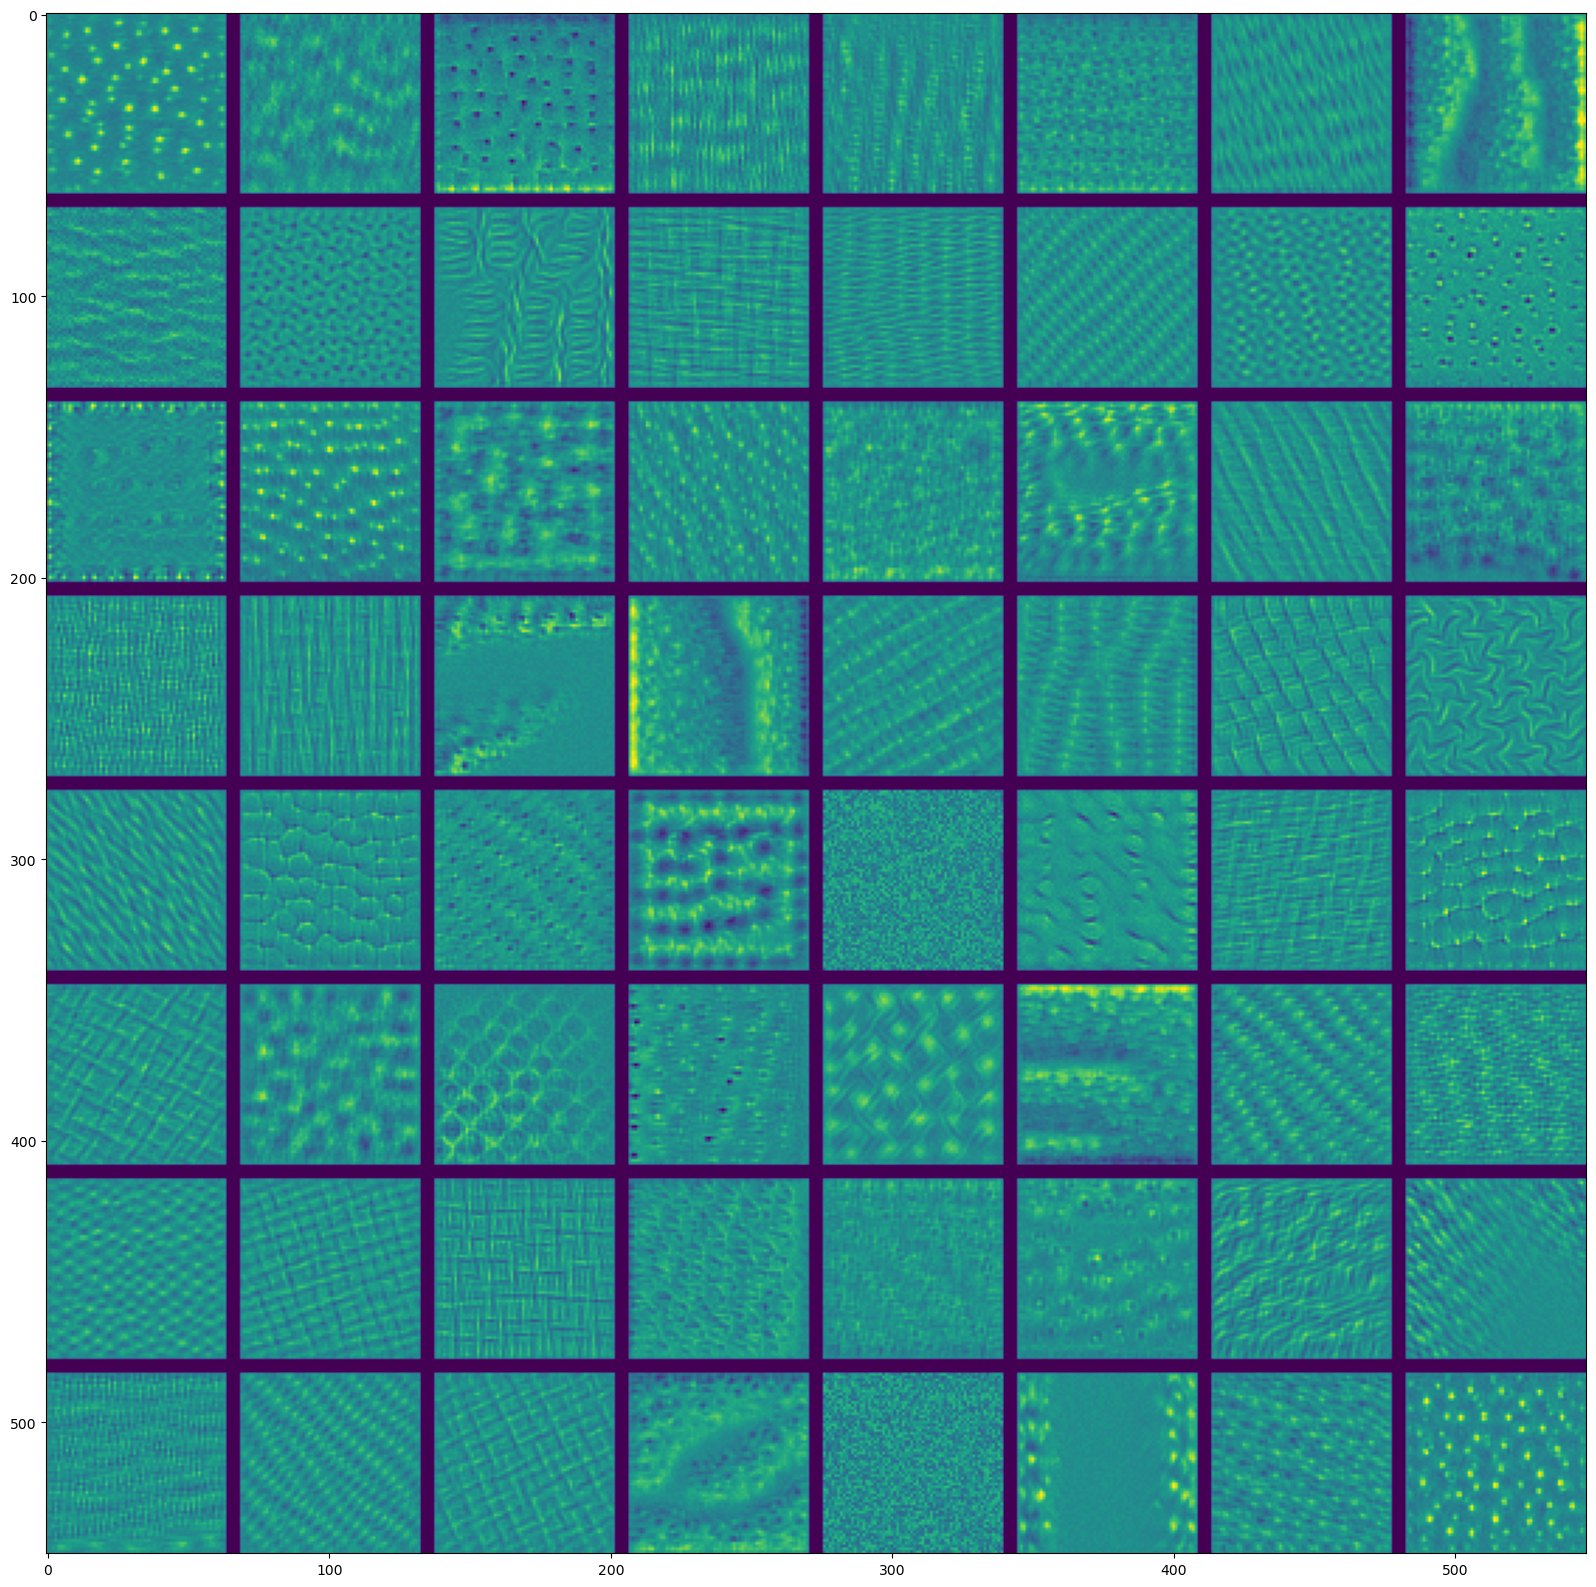

In [42]:
layer_name = 'block3_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
             vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results[:,:,0])

## 3. Visualizing heatmaps of class activation in an image

In [43]:
model = VGG16(weights='imagenet')

553467096/553467096 [==============================] - 61s 0us/step


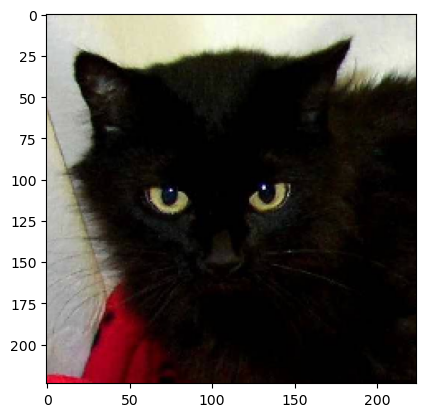

In [52]:
img = image.load_img('./../convnet_dog_cat/dogs-vs-cats-data-small/test/cats/cat.1500.jpg', target_size=(224, 224))

x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)

x = preprocess_input(x)

plt.imshow(img)

In [55]:
preds = model.predict(x)

print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02123394', 'Persian_cat', 0.32657108), ('n02124075', 'Egyptian_cat', 0.116568945), ('n02123045', 'tabby', 0.08573266)]


In [67]:
# retrieve second maximum
np.argmax(preds[0])

283

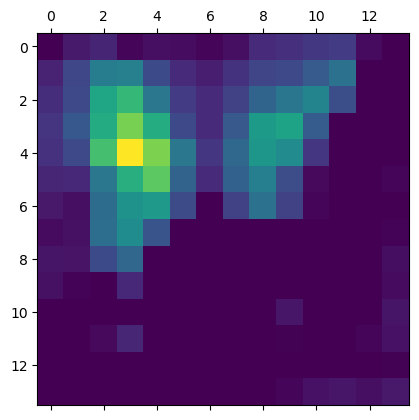

In [69]:
# Setting up the Grad-CAM algorithm

persian_cat_output = model.output[:, 285]


last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(persian_cat_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input],
                        [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])


for i in range(512):
        
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

heatmap = np.maximum(heatmap, 0)

heatmap /= np.max(heatmap)

plt.matshow(heatmap)

In [70]:
img = cv2.imread('./../convnet_dog_cat/dogs-vs-cats-data-small/test/cats/cat.1500.jpg')

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('./hetmap_for_cat.jpg', superimposed_img)

True